# Variazioni

Variazioni giornaliere.

> Max Pierini

I dati grezzi sono 

- filtrati con _Hampel filter_, finestra gaussiana di 7 giorni, $\sigma=2$ per isolare gli outliers dal trend
- smussati con media mobile, finestra gaussiana di 14 giorni, $\sigma=5$ per evidenziare il trend

In [1]:
import json
import requests
import datetime as dt

from IPython.display import display, Math, Latex, Image, HTML, Markdown

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
import matplotlib.ticker as mtick

from scipy.optimize import curve_fit, brentq
from scipy import stats as sps
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd

In [2]:
italy = None
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
italy = pd.read_csv(
    url,
    usecols=[
        'data', 
        'totale_casi', 'totale_positivi',
        'nuovi_positivi', 'variazione_totale_positivi',
        'deceduti', 'dimessi_guariti',
        'isolamento_domiciliare', 'ricoverati_con_sintomi', 'terapia_intensiva'
    ],
    parse_dates=['data'],
    index_col=['data'],
    squeeze=True).sort_index()

In [3]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
states = pd.read_csv(url,
    usecols=[
        'data', 'denominazione_regione',
        'totale_casi', 'totale_positivi',
        'nuovi_positivi', 'variazione_totale_positivi',
        'deceduti', 'dimessi_guariti',
        'isolamento_domiciliare', 'ricoverati_con_sintomi', 'terapia_intensiva'
    ],
                     parse_dates=['data'],
                     index_col=['denominazione_regione', 'data'],
                     squeeze=True).sort_index()
days = states.index.get_level_values('data').unique()
regions = states.index.get_level_values('denominazione_regione').unique().sort_values()

In [4]:
# find and fix outliers using Hampel filter
# Impl from: https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

def hampel_filter_pandas(input_series, window_size, n_sigmas=3.0):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    # the use of min_periods is to have rolling window extend towards
    # the end of the data series; in effect, we can apply hampel filter
    # to most recent observations
    # taken from: https://stackoverflow.com/questions/48953313/pandas-rolling-window-boundary-on-start-end-of-series/48953314#48953314
    rolling_window_size = 2*window_size+1
    rolling_median = input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).median()
    rolling_mad = k * input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).apply(MAD)
    # print(f'rolling_mad = {rolling_mad}, rolling_median = {rolling_median}')
    diff = np.abs(input_series - rolling_median)
    
    where = diff > (n_sigmas * rolling_mad)
    indices = np.argwhere(where.to_numpy()).flatten()
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

def hampel_filter_dataframe(dataframe, window, sigmas):
    framedict = {'data': dataframe.index}
    outdict = {}
    for col in dataframe.columns:
        filtered, outliers = hampel_filter_pandas(dataframe[col], window, sigmas)
        framedict.update({col: filtered})
        outdict.update({col: outliers})
    newframe = pd.DataFrame(framedict)
    newframe.set_index('data', inplace=True)
    return newframe, outdict

In [5]:
filtered_italy, outliers_italy = hampel_filter_dataframe(italy.diff(), 7, 2)

smoothed_italy = filtered_italy.rolling(14,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=5)

# Assolute

## Italia

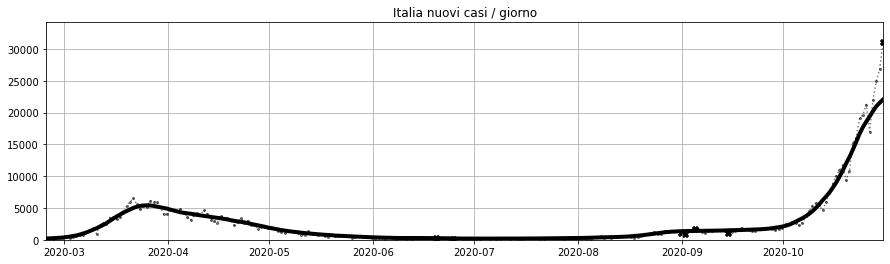

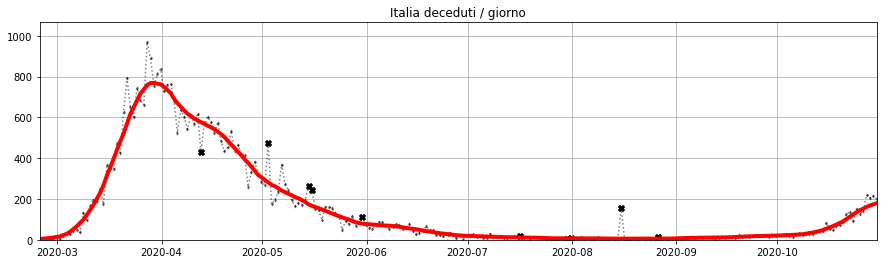

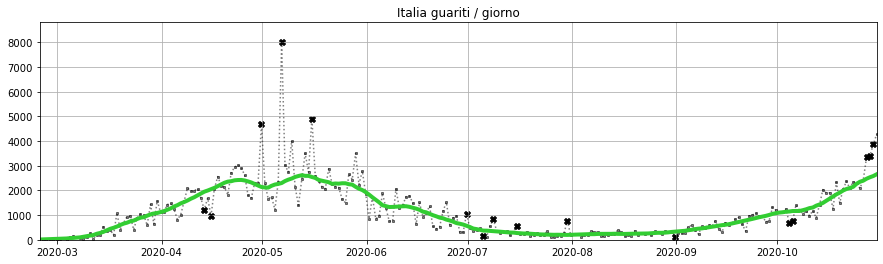

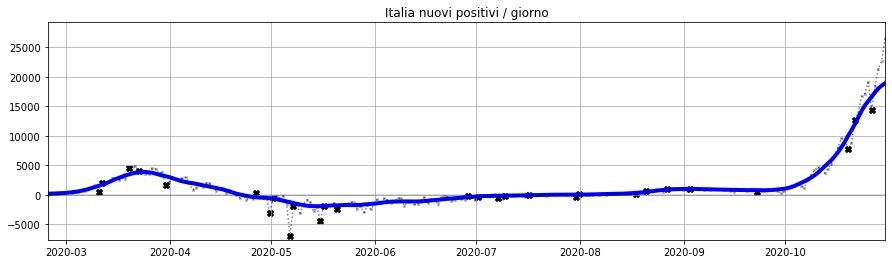

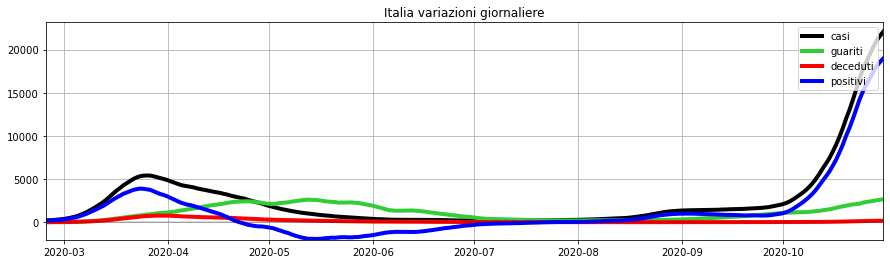

In [6]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(italy.index, italy['nuovi_positivi'], 'ok:', alpha=.5, ms=2)
for out in outliers_italy['totale_casi']:
    ax.scatter(italy.index[out], italy['nuovi_positivi'][out], marker='X', color='k')
ax.plot(italy.index, smoothed_italy['totale_casi'], 'k', lw=4)
ax.set_xlim(italy.index[0], italy.index[-1])
ax.set_ylim(0, italy['nuovi_positivi'].max()*1.1)
ax.set_title("Italia nuovi casi / giorno")
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(italy.index, italy['deceduti'].diff(), 'dk:', alpha=.5, ms=2)
ax.plot(italy.index, smoothed_italy['deceduti'], 'r', lw=4)
for out in outliers_italy['deceduti']:
    ax.scatter(italy.index[out], italy['deceduti'].diff()[out], marker='X', color='k')
ax.set_xlim(italy.index[0], italy.index[-1])
ax.set_ylim(0, italy['deceduti'].diff().max()*1.1)
ax.set_title("Italia deceduti / giorno")
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(italy.index, italy['dimessi_guariti'].diff(), 'sk:', alpha=.5, ms=2)
ax.plot(italy.index, smoothed_italy['dimessi_guariti'], 'limegreen', lw=4)
for out in outliers_italy['dimessi_guariti']:
    ax.scatter(italy.index[out], italy['dimessi_guariti'].diff()[out], marker='X', color='k')
ax.set_xlim(italy.index[0], italy.index[-1])
ax.set_ylim(0, italy['dimessi_guariti'].diff().max()*1.1)
ax.set_title("Italia guariti / giorno")
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(italy.index, italy['variazione_totale_positivi'], 'xk:', alpha=.5, ms=2)
ax.plot(italy.index, smoothed_italy['totale_positivi'], 'b', lw=4)
for out in outliers_italy['variazione_totale_positivi']:
    ax.scatter(italy.index[out], italy['variazione_totale_positivi'][out], marker='X', color='k')
ax.set_xlim(italy.index[0], italy.index[-1])
ax.set_ylim(italy['variazione_totale_positivi'].min()*1.1, italy['variazione_totale_positivi'].max()*1.1)
ax.axhline(0, c='k', alpha=.2)
ax.set_title("Italia nuovi positivi / giorno")
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(italy.index, smoothed_italy['totale_casi'], 'k', lw=4, label='casi')
ax.plot(italy.index, smoothed_italy['dimessi_guariti'], 'limegreen', lw=4, label='guariti')
ax.plot(italy.index, smoothed_italy['deceduti'], 'r', lw=4, label='deceduti')
ax.plot(italy.index, smoothed_italy['totale_positivi'], 'b', lw=4, label='positivi')
ax.set_xlim(italy.index[0], italy.index[-1])
ax.set_ylim(smoothed_italy['totale_positivi'].min()*1.05, smoothed_italy['totale_casi'].max()*1.05)
ax.axhline(0, c='k', alpha=.2)
ax.legend(loc='upper right')
ax.set_title("Italia variazioni giornaliere")
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

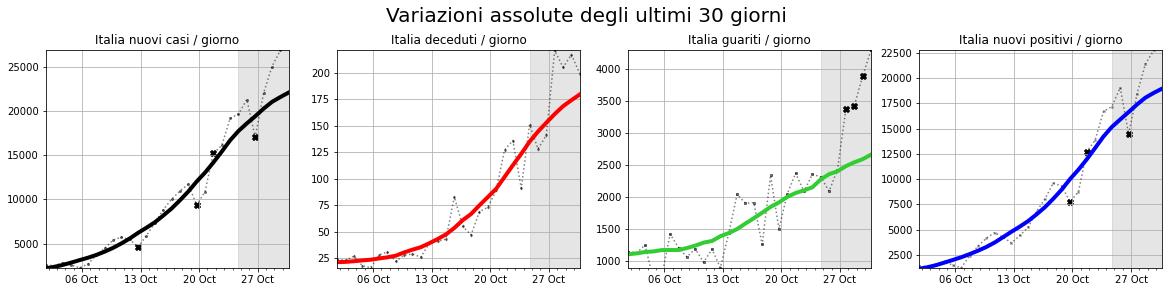

In [7]:
from_day = -30

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)

ax[0].plot(italy.index[from_day:], italy['nuovi_positivi'][from_day:], 'ok:', alpha=.5, ms=2)
for out in outliers_italy['nuovi_positivi']:
    ax[0].scatter(italy.index[out], italy['nuovi_positivi'][out], marker='X', color='k')
ax[0].plot(italy.index[from_day:], smoothed_italy['totale_casi'][from_day:], 'k', lw=4)
ax[0].set_xlim(italy.index[from_day], italy.index[-1]+pd.Timedelta(days=1))
ax[0].set_ylim(filtered_italy['totale_casi'][from_day:].min(), filtered_italy['totale_casi'][from_day:].max())
ax[0].set_title("Italia nuovi casi / giorno")
ax[0].grid(axis='both')

ax[1].plot(italy.index[from_day:], italy['deceduti'].diff()[from_day:], 'dk:', alpha=.5, ms=2)
ax[1].plot(italy.index[from_day:], smoothed_italy['deceduti'][from_day:], 'r', lw=4)
for out in outliers_italy['deceduti']:
    ax[1].scatter(italy.index[out], italy['deceduti'].diff()[out], marker='X', color='k')
ax[1].set_xlim(italy.index[from_day], italy.index[-1]+pd.Timedelta(days=1))
ax[1].set_ylim(filtered_italy['deceduti'][from_day:].min(), filtered_italy['deceduti'][from_day:].max())
ax[1].set_title("Italia deceduti / giorno")
ax[1].grid(axis='both')

ax[2].plot(italy.index[from_day:], italy['dimessi_guariti'].diff()[from_day:], 'sk:', alpha=.5, ms=2)
ax[2].plot(italy.index[from_day:], smoothed_italy['dimessi_guariti'][from_day:], 'limegreen', lw=4)
for out in outliers_italy['dimessi_guariti']:
    ax[2].scatter(italy.index[out], italy['dimessi_guariti'].diff()[out], marker='X', color='k')
ax[2].set_xlim(italy.index[from_day], italy.index[-1]+pd.Timedelta(days=1))
ax[2].set_ylim(filtered_italy['dimessi_guariti'][from_day:].min(), filtered_italy['dimessi_guariti'][from_day:].max())
ax[2].set_title("Italia guariti / giorno")
ax[2].grid(axis='both')

ax[3].plot(italy.index[from_day:], italy['variazione_totale_positivi'][from_day:], 'xk:', alpha=.5, ms=2)
ax[3].plot(italy.index[from_day:], smoothed_italy['totale_positivi'][from_day:], 'b', lw=4)
for out in outliers_italy['variazione_totale_positivi']:
    ax[3].scatter(italy.index[out], italy['variazione_totale_positivi'][out], marker='X', color='k')
ax[3].set_xlim(italy.index[from_day], italy.index[-1])
ax[3].set_ylim(
    filtered_italy['totale_positivi'][from_day:].min(), 
    filtered_italy['totale_positivi'][from_day:].max()
)
ax[3].axhline(0, c='k', alpha=.2)
ax[3].set_title("Italia nuovi positivi / giorno")
ax[3].grid(axis='both')

ax[3].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax[3].xaxis.set_minor_locator(mdates.DayLocator())

for i in np.arange(0, 4):
    ax[i].fill_between(italy.index[-7:], -1e15, 1e15, color='k', alpha=.1)

fig.suptitle(f"Variazioni assolute degli ultimi {-from_day} giorni", fontsize=20, y=1.03)

fig.set_facecolor('w'); plt.show();

## Regioni

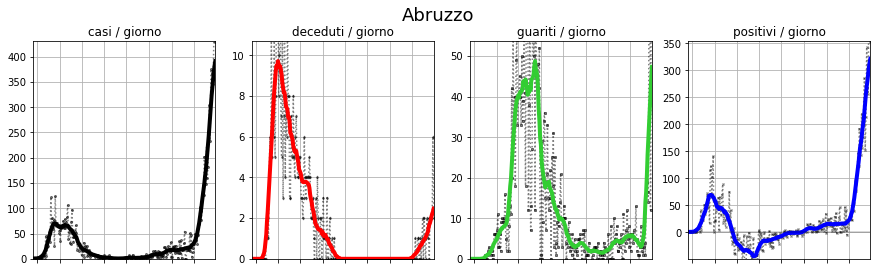

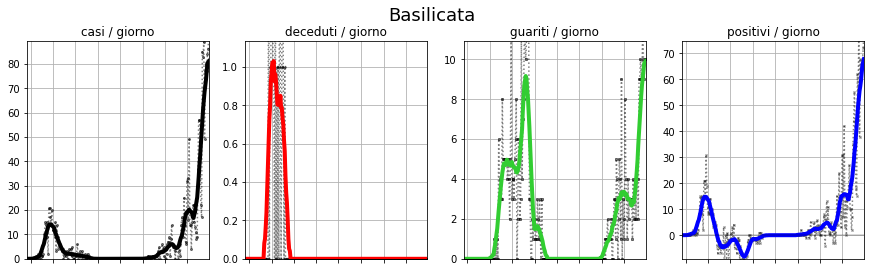

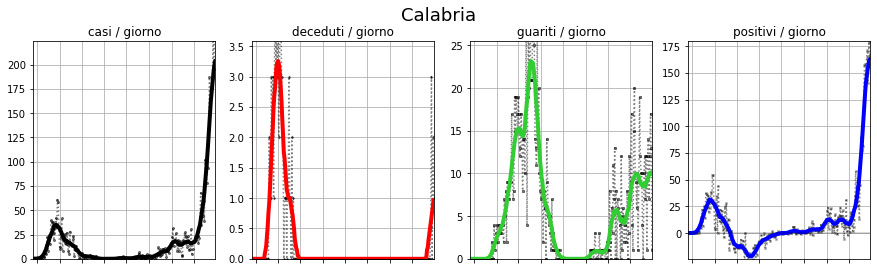

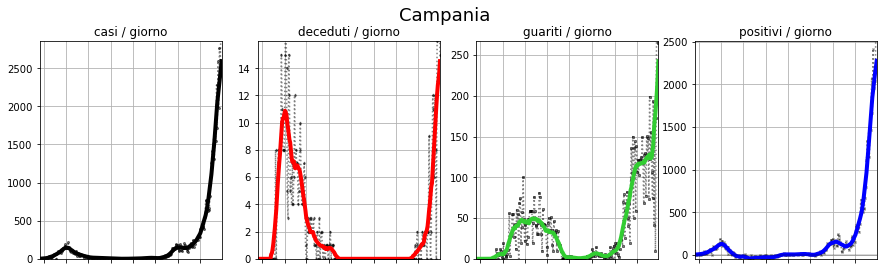

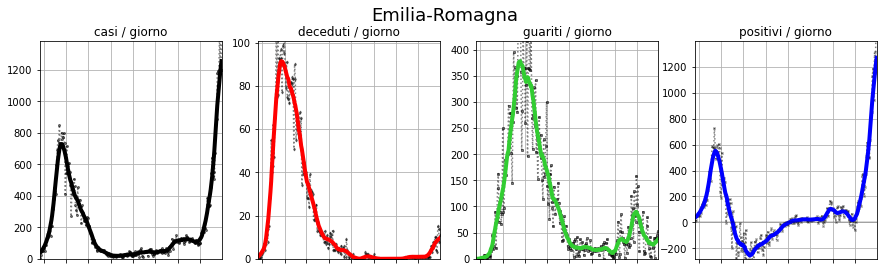

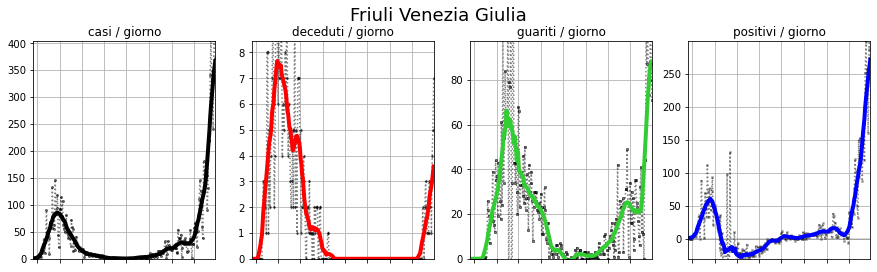

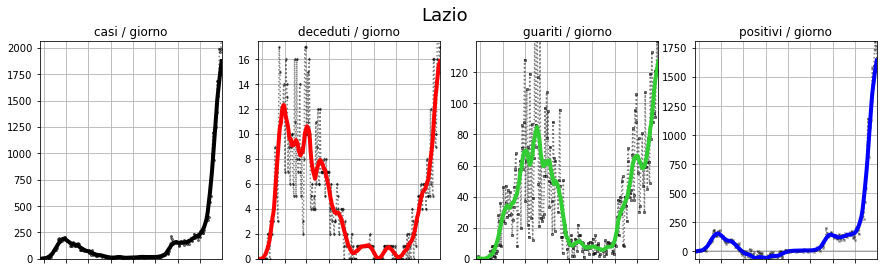

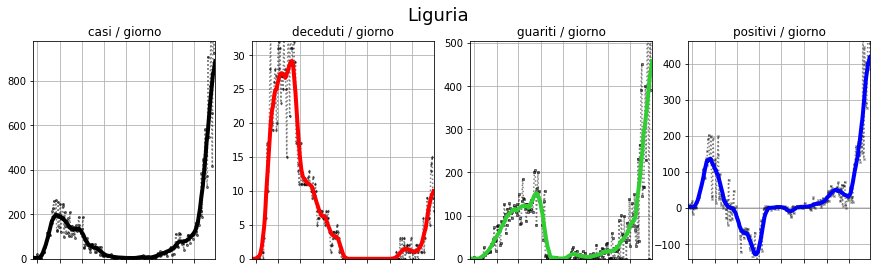

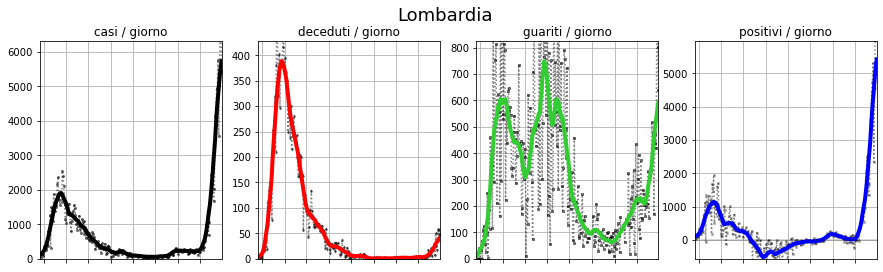

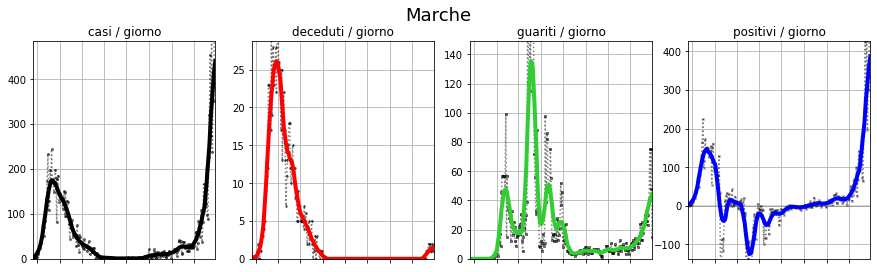

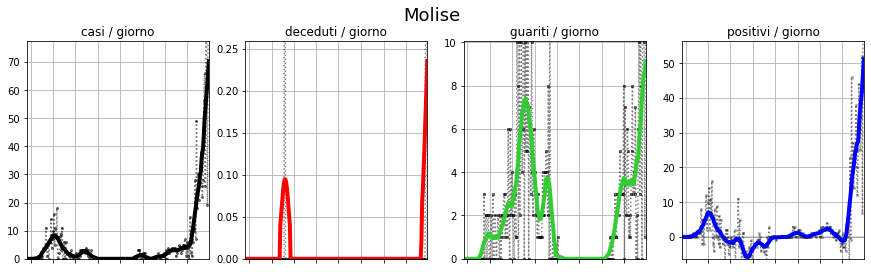

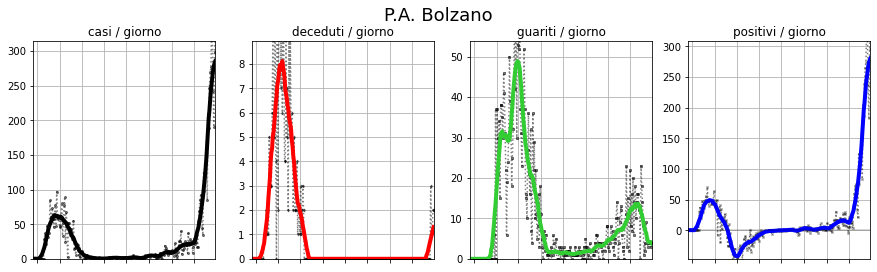

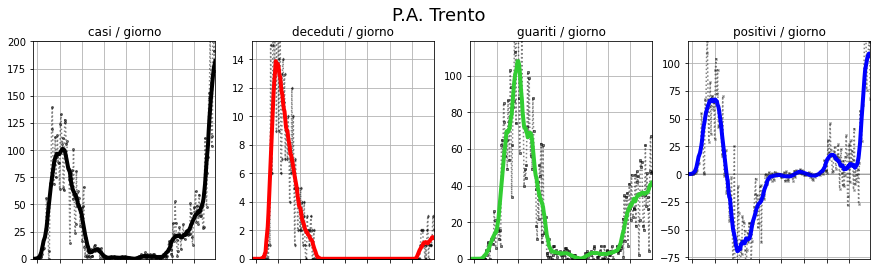

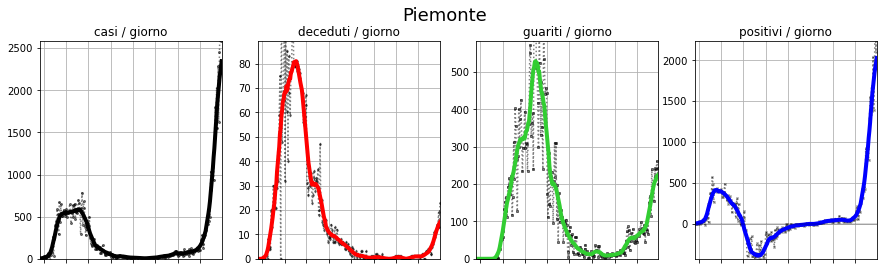

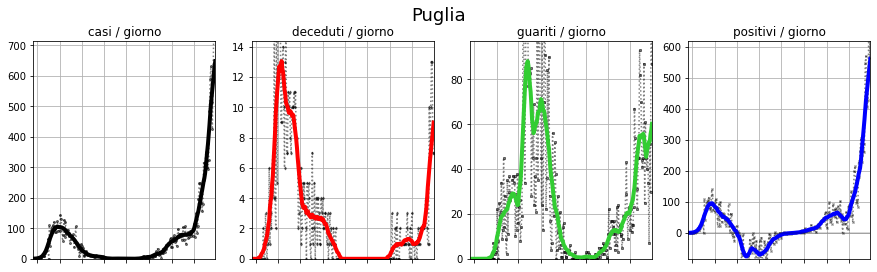

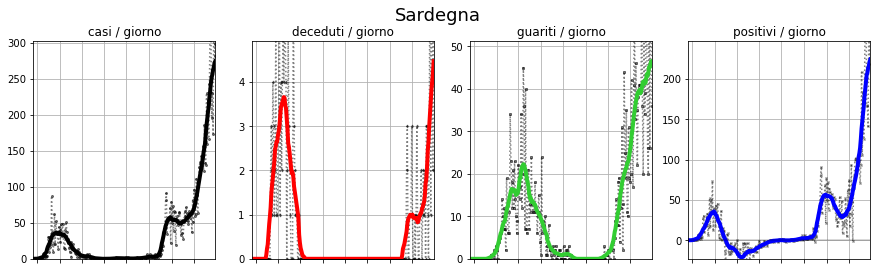

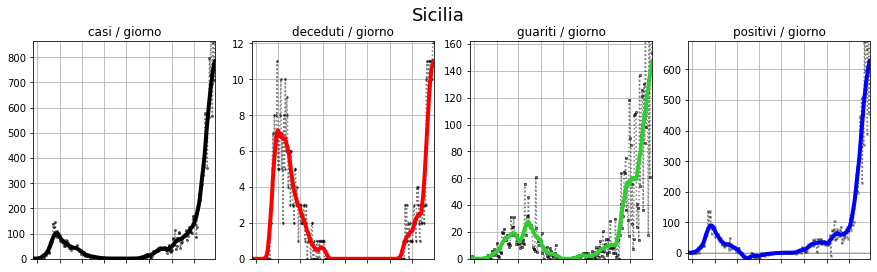

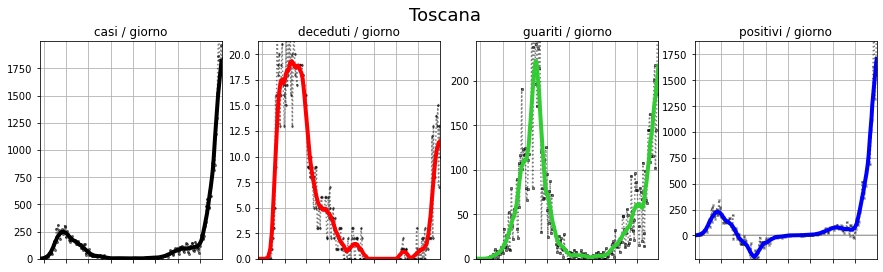

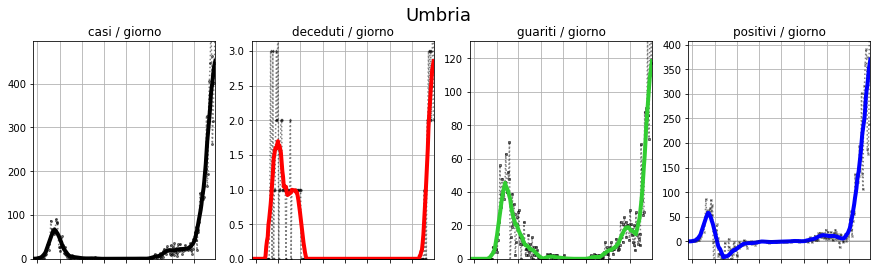

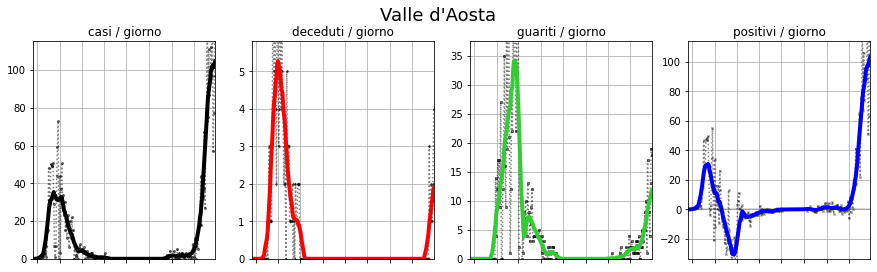

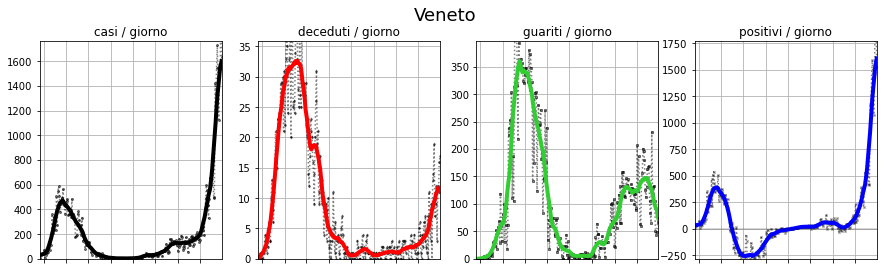

In [8]:
for region in regions:
    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    fig.suptitle(region, y=1, fontsize=18)
    filtered_states, outliers_states = hampel_filter_dataframe(states.loc[region].diff(), 7, 2)

    smoothed_states = filtered_states.rolling(14,
        win_type='gaussian',
        min_periods=3,
        center=True).mean(std=5)
    
    ax[0].plot(days, filtered_states['totale_casi'], 'ok:', alpha=.5, ms=2)
    ax[0].plot(days, smoothed_states['totale_casi'], 'k', lw=4)
    ax[0].set_xlim(days[0], days[-1])
    ax[0].set_ylim(0, smoothed_states['totale_casi'].max()*1.1)
    ax[0].set_title(f"casi / giorno")
    ax[0].set_xticklabels([])
    ax[0].grid(axis='both')

    ax[1].plot(days, filtered_states['deceduti'], 'dk:', alpha=.5, ms=2)
    ax[1].plot(days, smoothed_states['deceduti'], 'r', lw=4)
    ax[1].set_xlim(days[0], days[-1])
    ax[1].set_ylim(0, smoothed_states['deceduti'].max()*1.1)
    ax[1].set_title(f"deceduti / giorno")
    ax[1].set_xticklabels([])
    ax[1].grid(axis='both')

    ax[2].plot(days, filtered_states['dimessi_guariti'], 'sk:', alpha=.5, ms=2)
    ax[2].plot(days, smoothed_states['dimessi_guariti'], 'limegreen', lw=4)
    ax[2].set_xlim(days[0], days[-1])
    ax[2].set_ylim(0, smoothed_states['dimessi_guariti'].max()*1.1)
    ax[2].set_title(f"guariti / giorno")
    ax[2].set_xticklabels([])
    ax[2].grid(axis='both')

    ax[3].plot(days, filtered_states['totale_positivi'], 'xk:', alpha=.5, ms=2)
    ax[3].plot(days, smoothed_states['totale_positivi'], 'b', lw=4)
    ax[3].set_xlim(days[0], days[-1])
    ax[3].set_ylim(
        smoothed_states['totale_positivi'].min()*1.1, 
        smoothed_states['totale_positivi'].max()*1.1
    )
    ax[3].axhline(0, c='k', alpha=.2)
    ax[3].set_title(f"positivi / giorno")
    ax[3].set_xticklabels([])
    ax[3].grid(axis='both')

    fig.set_facecolor('w'); plt.show();

# Percentuali

## Italia

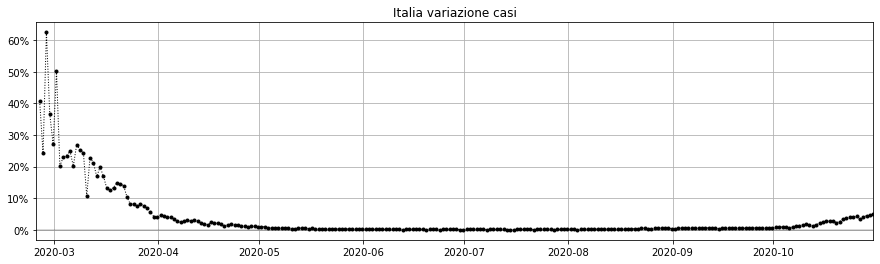

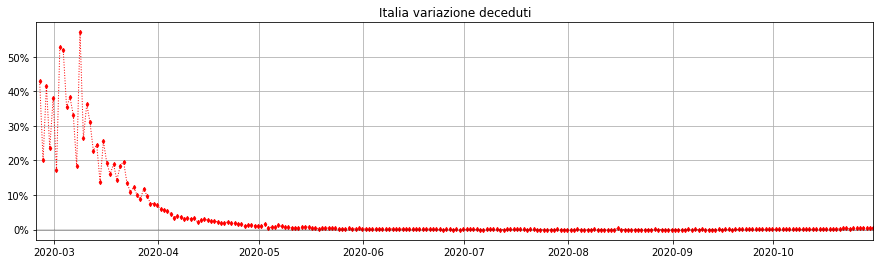

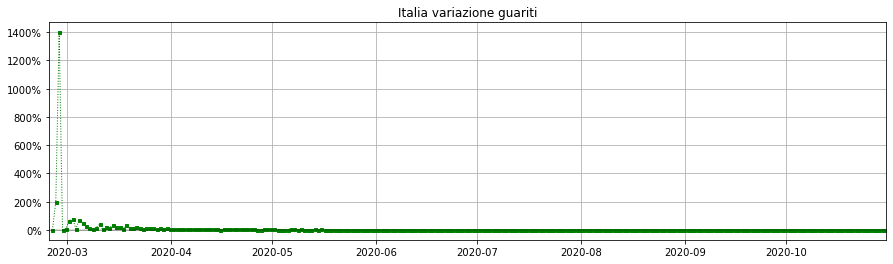

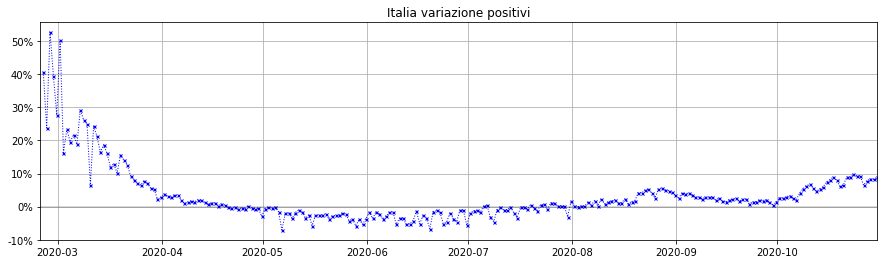

In [9]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(italy.index, italy['totale_casi'].pct_change(), 'ok:', ms=3, lw=1)
ax.set_xlim(italy.index[0], italy.index[-1])
ax.axhline(0, c='k', alpha=.2)
ax.set_title("Italia variazione casi")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(italy.index, italy['deceduti'].pct_change(), 'dr:', ms=3, lw=1)
ax.set_xlim(italy.index[0], italy.index[-1])
ax.axhline(0, c='k', alpha=.2)
ax.set_title("Italia variazione deceduti")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(italy.index, italy['dimessi_guariti'].pct_change(), 'sg:', ms=3, lw=1)
ax.set_xlim(italy.index[0], italy.index[-1])
ax.axhline(0, c='k', alpha=.2)
ax.set_title("Italia variazione guariti")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(italy.index, italy['totale_positivi'].pct_change(), 'xb:', ms=3, lw=1)
ax.set_xlim(italy.index[0], italy.index[-1])
ax.axhline(0, c='k', alpha=.2)
ax.set_title("Italia variazione positivi")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

## Regioni

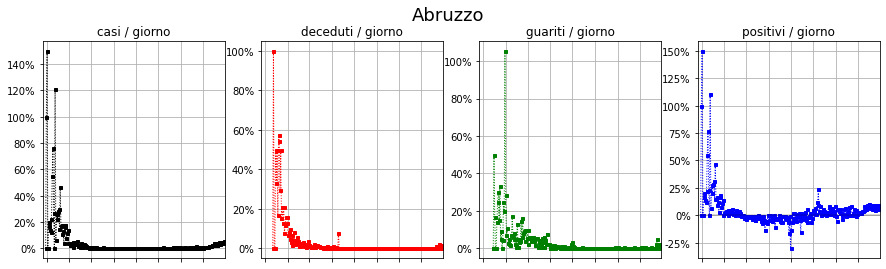

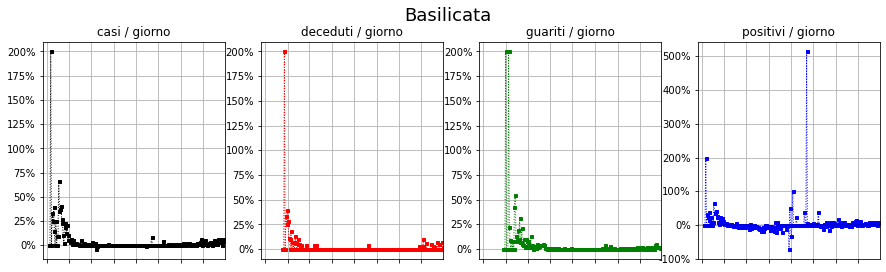

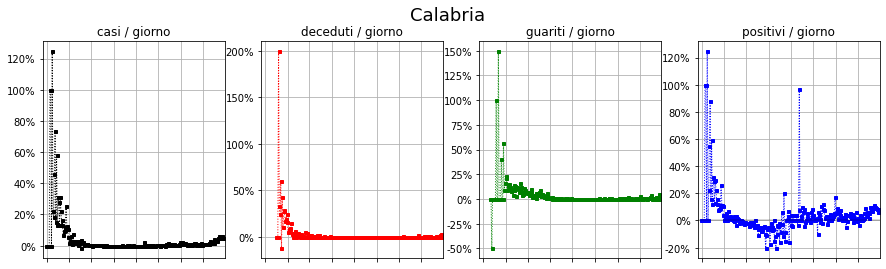

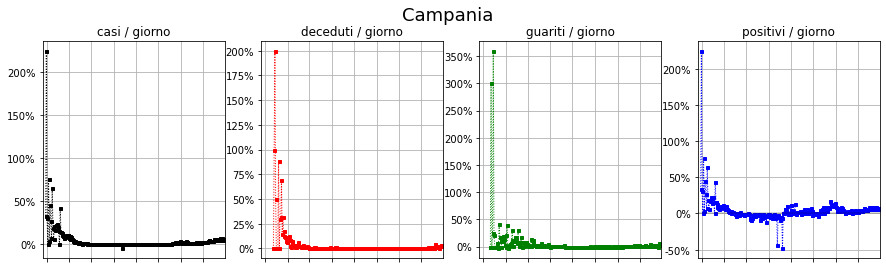

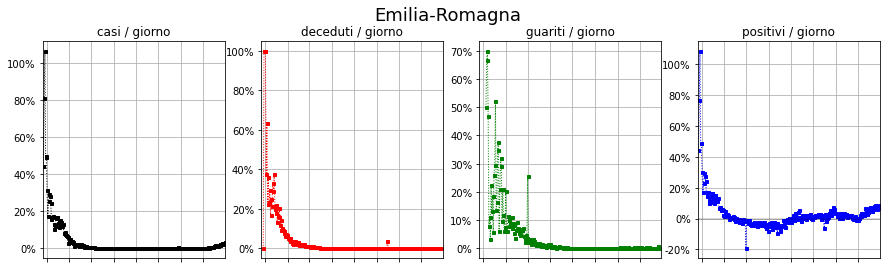

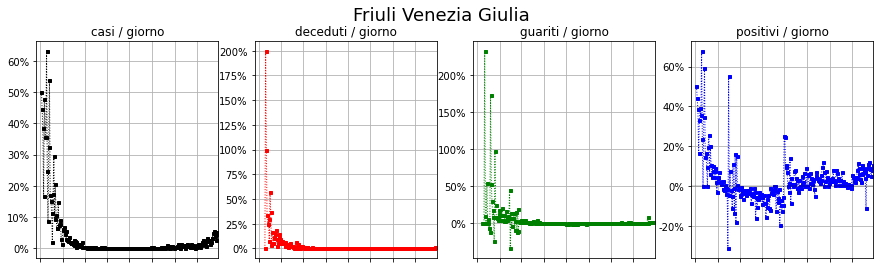

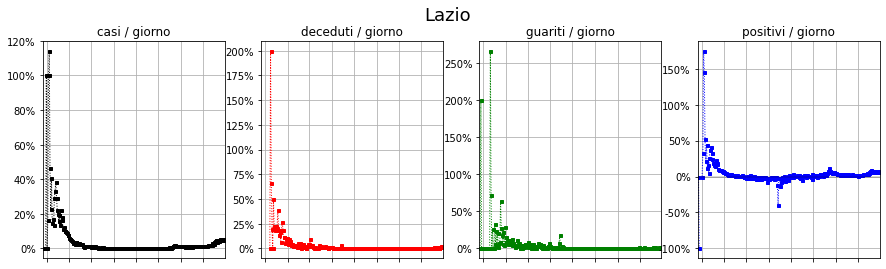

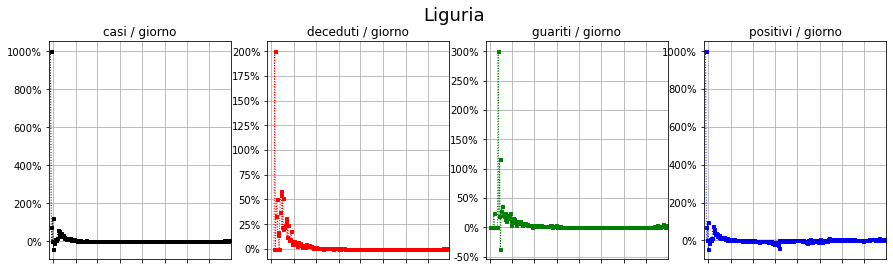

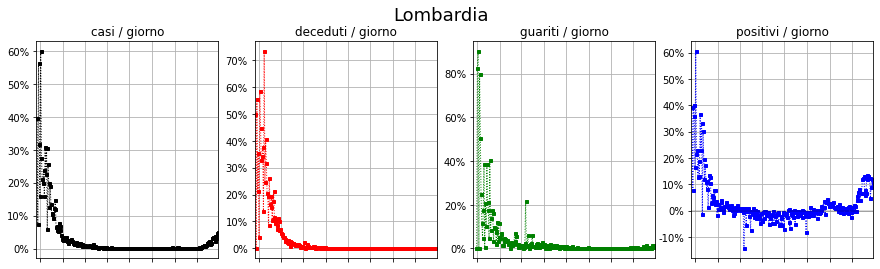

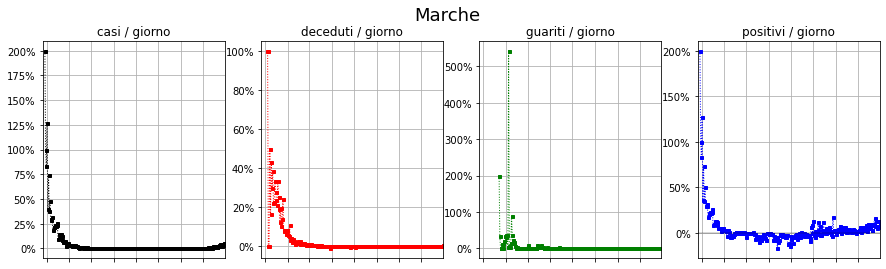

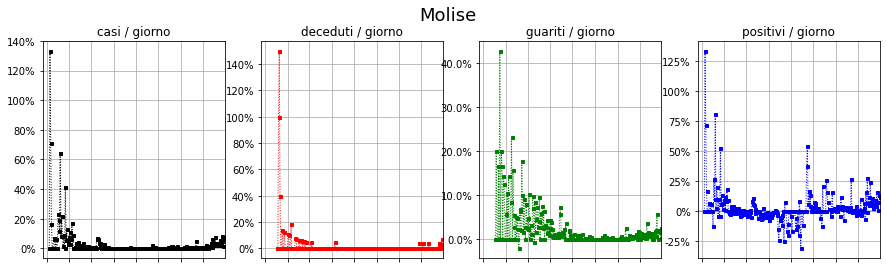

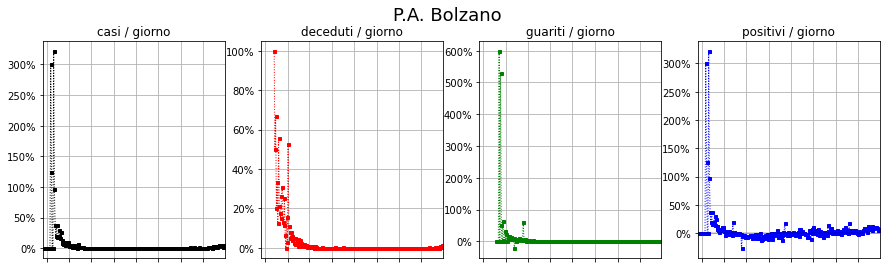

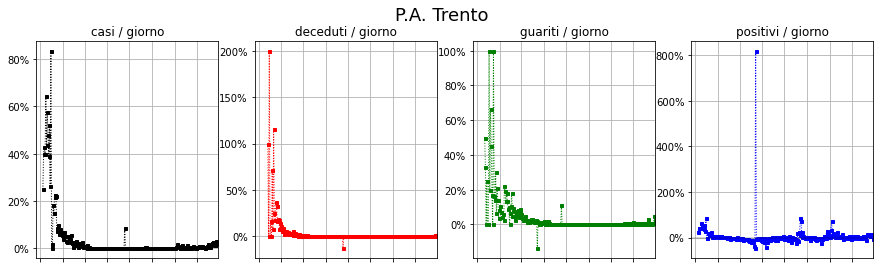

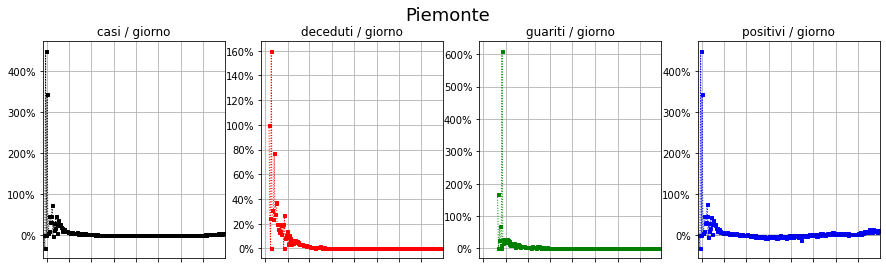

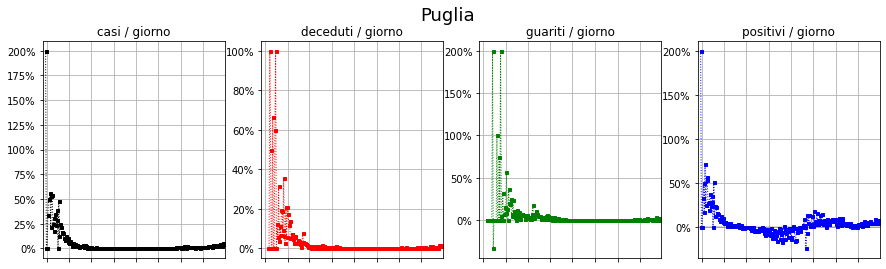

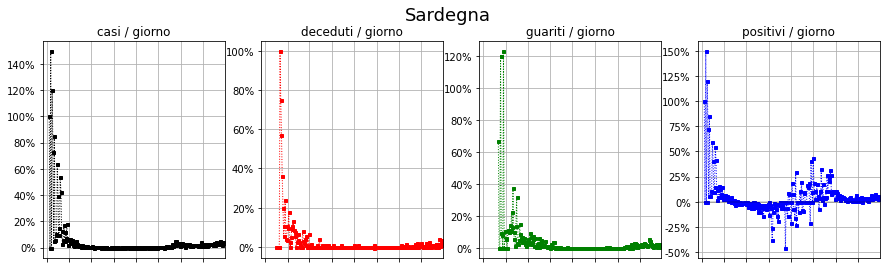

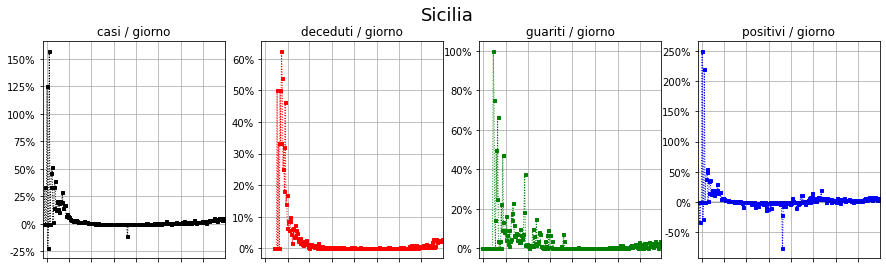

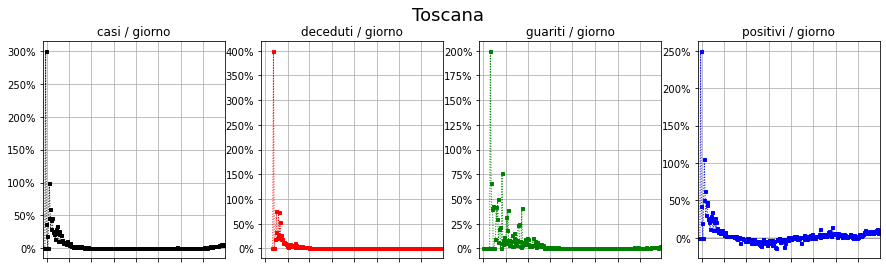

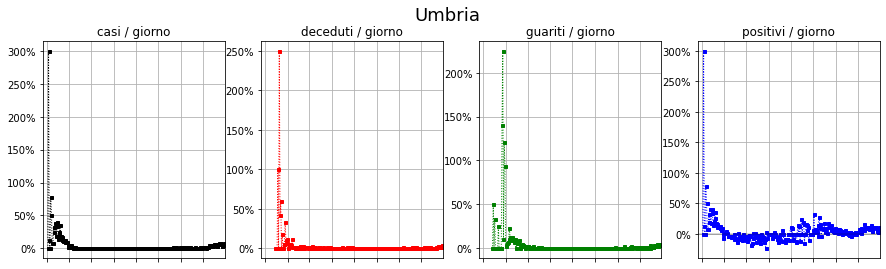

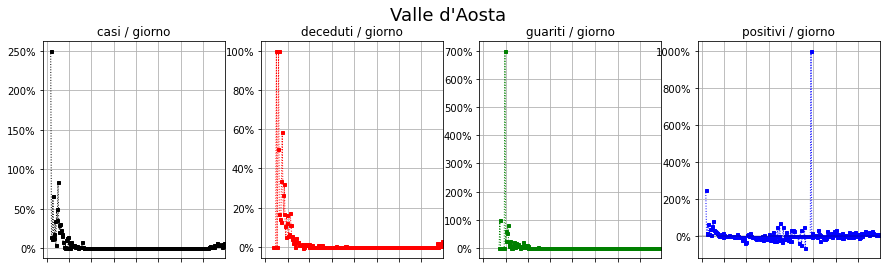

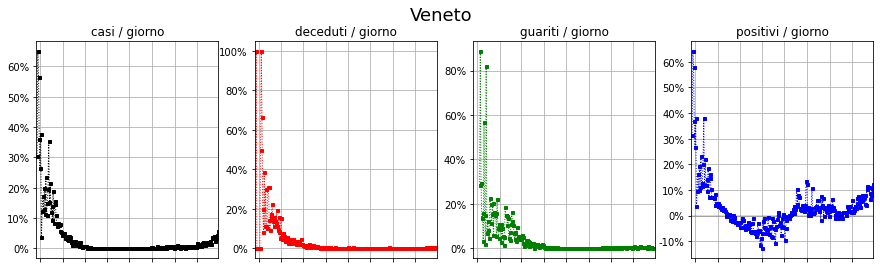

In [10]:
for region in regions:
    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    fig.suptitle(region, y=1, fontsize=18)
    
    _ = """
    filtered_states, outliers_states = hampel_filter_dataframe(states.loc[region], 7, 2)

    smoothed_states = filtered_states.rolling(14,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=5)"""
    
    ax[0].plot(days, states.loc[region]['totale_casi'].pct_change(), 'sk:', lw=1, ms=3)
    ax[0].set_xlim(days[0], days[-1])
    #ax[0].set_ylim(0, smoothed_states.loc[region]['nuovi_positivi'].max()*1.1)
    ax[0].set_title(f"casi / giorno")
    ax[0].set_xticklabels([])
    ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[0].grid(axis='both')

    ax[1].plot(days, states.loc[region]['deceduti'].pct_change(), 'sr:', lw=1, ms=3)
    ax[1].set_xlim(days[0], days[-1])
    #ax[1].set_ylim(0, smoothed_states.loc[region]['deceduti'].diff().max()*1.1)
    ax[1].set_title(f"deceduti / giorno")
    ax[1].set_xticklabels([])
    ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[1].grid(axis='both')

    ax[2].plot(days, states.loc[region]['dimessi_guariti'].pct_change(), 'sg:', lw=1, ms=3)
    ax[2].set_xlim(days[0], days[-1])
    #ax[2].set_ylim(0, smoothed_states.loc[region]['dimessi_guariti'].diff().max()*1.1)
    ax[2].set_title(f"guariti / giorno")
    ax[2].set_xticklabels([])
    ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[2].grid(axis='both')

    ax[3].plot(days, states.loc[region]['totale_positivi'].pct_change(), 'sb:', lw=1, ms=3)
    ax[3].set_xlim(days[0], days[-1])
    #ax[3].set_ylim(smoothed_states.loc[region]['variazione_totale_positivi'].min()*1.1, smoothed_states.loc[region]['variazione_totale_positivi'].max()*1.1)
    ax[3].axhline(0, c='k', alpha=.2)
    ax[3].set_title(f"positivi / giorno")
    ax[3].set_xticklabels([])
    ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[3].grid(axis='both')

    fig.set_facecolor('w'); plt.show();